In [1]:
from mimic.utilities import *

from mimic.model_infer.infer_gLV_bayes import *
from mimic.model_infer import *
from mimic.model_simulate import *
from mimic.model_simulate.sim_gLV import *


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as at
import pickle
import cloudpickle


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Repeat Rutter & Dekker et al 2024 analysis

In [2]:
def get_data(input_data):
    # Read the CSV file
    d = pd.read_csv(input_data)
    
    # Calculate the mean of columns 2 to 5 (index 1 to 4) for each row
    # Take only time course up to t=400
    X1_bar = d.iloc[1:21, 1:5].mean(axis=1)
    
    # Calculate the mean of columns 6 to 9 (index 5 to 8) for each row
    X2_bar = d.iloc[1:21, 5:9].mean(axis=1)
    
    # Combine the first column with the calculated means
    obs = pd.DataFrame({
        'time': d.iloc[1:21, 0],
        'X1_bar': X1_bar,
        'X2_bar': X2_bar
    })
    
    # Replace negative values with 0
    obs[obs < 0] = 0
    
    return obs



def plot_growth_curves(data):
    plt.figure(figsize=(10, 6))
    
    # Plotting X1_bar
    plt.plot(data['time'], data['X1_bar'], label='X1_bar')
    
    # Plotting X2_bar
    plt.plot(data['time'], data['X2_bar'], label='X2_bar')
    
    # Adding labels and title
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Growth Curves of X1_bar and X2_bar')
    
    # Adding a legend
    plt.legend()
    
    # Display the plot
    plt.show()
    
    

In [3]:
PM3_EntA_data = get_data('PM3-EntA-coculture.csv')

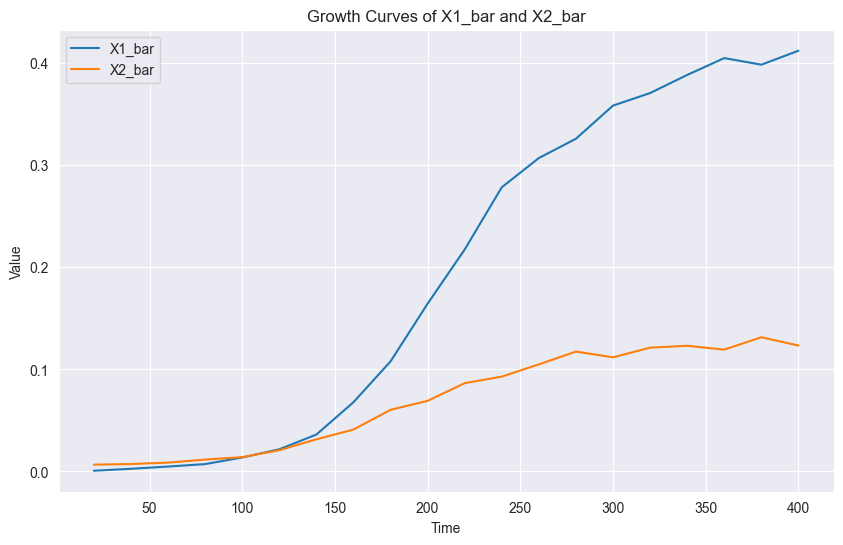

In [4]:
# Visualise the mean of the growth curves of both species grown in co-culture together
plot_growth_curves(PM3_EntA_data)

In [5]:
# Extract data and convert to numpyarrays

yobsdf = PM3_EntA_data.iloc[:, [1,2]]
yobs = yobsdf.to_numpy()
timesa = PM3_EntA_data.iloc[:, 0]
times = timesa.to_numpy()

In [6]:
print(yobs)

[[0.00072192 0.00665308]
 [0.00260168 0.00728166]
 [0.00481121 0.00865545]
 [0.00721984 0.0116635 ]
 [0.01367956 0.01402044]
 [0.02169891 0.02080109]
 [0.03614343 0.03148157]
 [0.06780534 0.04102799]
 [0.1078001  0.06039157]
 [0.16433957 0.06916043]
 [0.21739263 0.08649903]
 [0.27834507 0.0928716 ]
 [0.30699755 0.10491079]
 [0.325903   0.117422  ]
 [0.35835908 0.11179925]
 [0.37063256 0.12125911]
 [0.38838541 0.12308959]
 [0.40489237 0.11932429]
 [0.39841823 0.13147344]
 [0.41210938 0.12333229]]


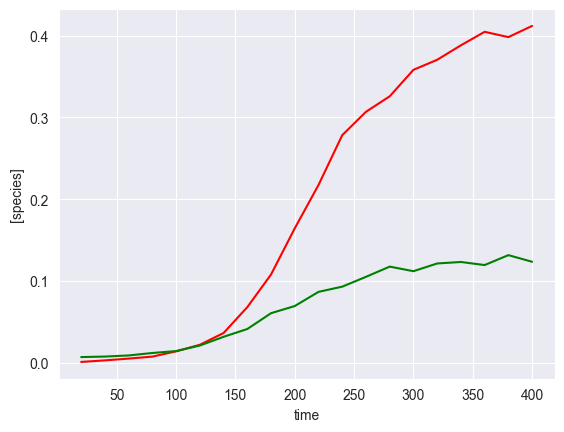

In [7]:
plot_gLV(yobs, times)

In [8]:
X, F = linearize_time_course_16S(yobs, times)
print(X.shape)
print(F.shape)


(19, 3)
(19, 2)


In [9]:
# Define priors
num_species = F.shape[1]


mu = np.array([0.03, 0.03])

M = np.zeros((num_species, num_species))
np.fill_diagonal(M, [-0.2, -0.2])
M[0, 1] = -0.1  # M12
M[1, 0] = -0.2  # M21

X shape: (19, 3)
F shape: (19, 2)
Number of species: 2
Used manually determined mu
Used manually determined M
mu_hat: [[0.62372188 0.20580784]]
M_hat_vals: [[ 0.18536165 -0.34720228]
 [-0.28412047  0.04271843]]
M_hat: [[ 0.18536165 -0.34720228]
 [-0.28412047  0.04271843]]
model mean before: [[0.62196542 0.2058414 ]
 [0.62213526 0.20521559]
 [0.6221545  0.20450712]
 [0.62174632 0.20379934]
 [0.62227405 0.20165719]
 [0.62183401 0.19916252]
 [0.62147693 0.1946036 ]
 [0.6246335  0.18401832]
 [0.6265454  0.17095923]
 [0.63453424 0.15170319]
 [0.63944199 0.13402372]
 [0.64892966 0.11313312]
 [0.65082015 0.10369921]
 [0.6507698  0.09766966]
 [0.65838345 0.08616064]
 [0.65797075 0.08230337]
 [0.66074137 0.07621773]
 [0.66487092 0.07032563]
 [0.66021905 0.07309246]]
Y_obs: [[ 0.92685466  0.41073858]
 [ 0.13638913 -0.13921036]
 [ 0.52885361  0.65524675]
 [ 0.1948959   0.26417048]
 [ 0.71968332  0.21656313]
 [ 0.31400059  0.38405556]
 [ 0.46047768  0.39689617]
 [ 0.45076077 -0.21886853]
 [ 1.3026

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, mu_hat, M_0_0_hat_prior, M_0_1_hat_prior, M_1_0_hat_prior, M_1_1_hat_prior]


Output()

Output()

Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mu_hat_np shape: (2,)
M_hat_np shape: (2, 2)


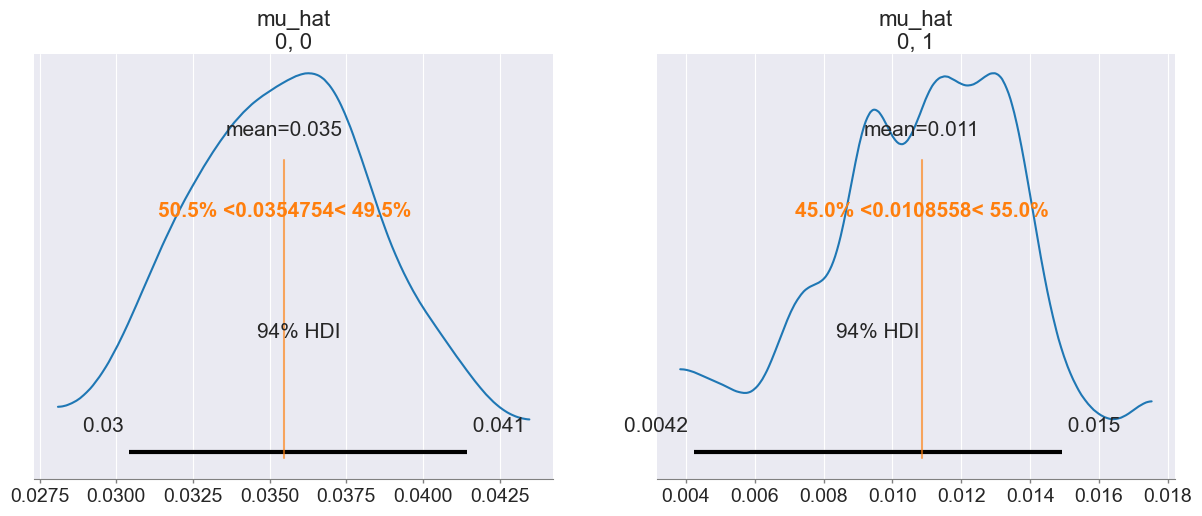

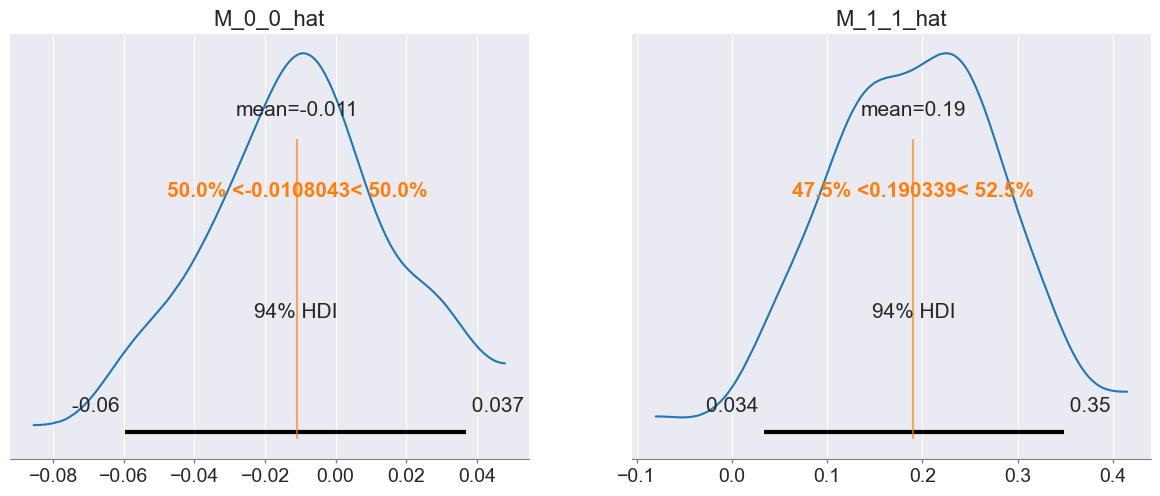

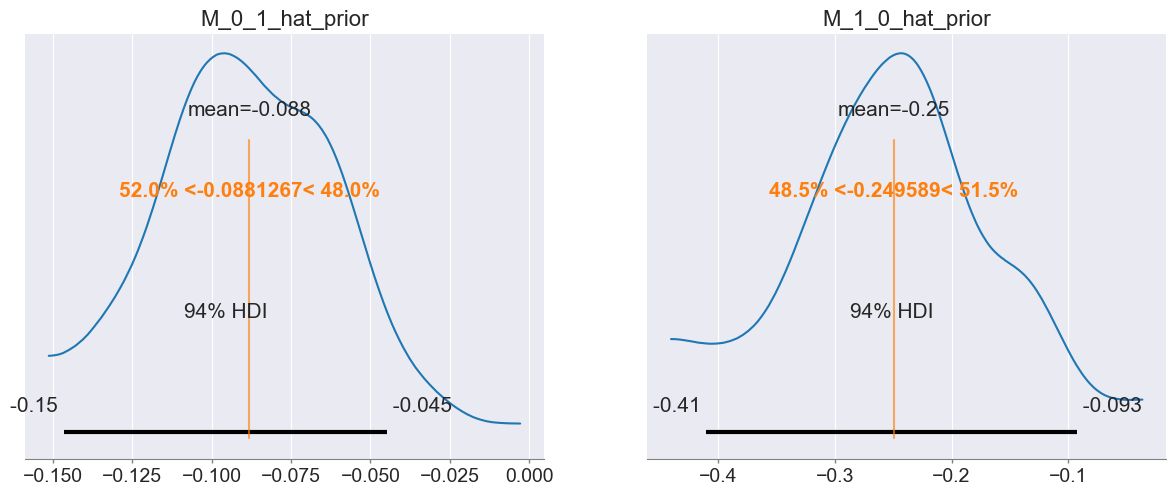

idata type after posterior extraction: <class 'arviz.data.inference_data.InferenceData'>


In [13]:
# Perform Bayesian inference without shrinkage

inference = infergLVbayes(X, F, mu, M)
#idata, mu_hat_np, M_hat_np = inference.run_bayes_gLV()
idata, var_names = inference.run_bayes_gLV_test()


In [11]:
#inference.plot_posterior_a(idata, mu_hat_np, M_hat_np)

In [14]:
type(idata)
type(var_names)

list

In [15]:
# Print summary

summary = az.summary(idata, var_names=["mu_hat", "M_hat", "sigma"] + var_names)
print(summary[["mean", "sd", "r_hat"]])


# Save posterior samples to file
az.to_netcdf(idata, 'model_posterior.nc')

                  mean     sd  r_hat
mu_hat[0, 0]     0.035  0.003   1.01
mu_hat[0, 1]     0.011  0.003   1.12
M_hat[0, 0]     -0.011  0.026   1.00
M_hat[0, 1]     -0.088  0.028   1.00
M_hat[1, 0]     -0.250  0.083   1.01
M_hat[1, 1]      0.190  0.090   1.01
sigma[0]         0.007  0.001   1.03
M_0_0_hat       -0.011  0.026   1.00
M_1_1_hat        0.190  0.090   1.01
M_0_1_hat_prior -0.088  0.028   1.00
M_1_0_hat_prior -0.250  0.083   1.01


'model_posterior.nc'

(2, 100, 2, 2)
(2, 100, 1, 2)
Using the following parameters for gLV simulation: {'num_species': 2, 'mu': array([0.03538069, 0.01120599]), 'M': array([[-0.01053818, -0.08948999],
       [-0.24733571,  0.19514163]]), 'epsilon': array([], shape=(2, 0), dtype=float64)}


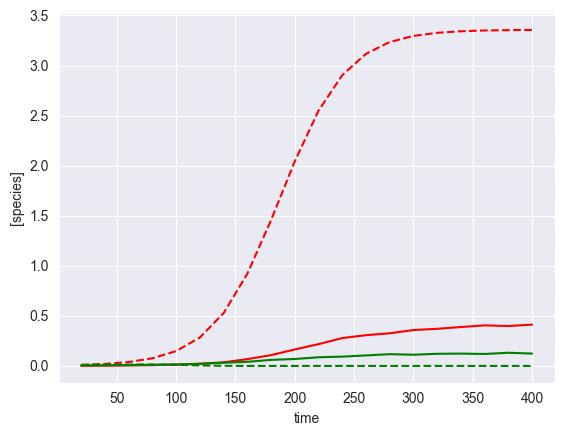

In [16]:
# Compare model parameters to the data
num_species = F.shape[1]
#init_species = 10 * np.ones(num_species)
init_species = 0.01 * np.ones(num_species)

print( idata.posterior["M_hat"].values.shape )

print( idata.posterior["mu_hat"].values.shape )

# # get median posterior values   
M_h = np.median(idata.posterior["M_hat"].values, axis=(0,1))

mu_h = np.median(idata.posterior["mu_hat"].values, axis=(0, 1))
mu_h = mu_h.flatten()

#mu_h = idata.posterior['mu_hat'].mean(dim=('chain', 'draw')).values.flatten()
#M_h= idata.posterior['M_hat'].mean(dim=('chain', 'draw')).values

predictor = sim_gLV(num_species=num_species,
                    M=M_h,
                    mu=mu_h
                 )
yobs_h, _, _, _, _ = predictor.simulate(times=times, init_species=init_species)

plot_fit_gLV(yobs, yobs_h, times)
#compare_params(mu=(mu, mu_h), M=(M, M_h) )


## Perform Bayesian inference with shrinkage

In [9]:
n_obs = times.shape[0] - 1
num_species = F.shape[1]
nX = num_species
noise_stddev = 0.1


# Params for shrinkage on M_ij (non diagonal elements)
DA = nX*nX - nX

#proportion = 3 / (5 * 4)  # Proportion for num_species = 5
#DA0 = int(proportion * num_species * (num_species - 1))

#DA0 = 3     # expected number of non zero entries in M_ij
N = n_obs - 2

In [10]:
print(N)

17


DA: 2, DA0: 1, N: 17, noise_stddev: 0.1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, mu_hat, M_ii_hat, c2, tau, lam, M_ij_hat]


Output()

Output()

Sampling 2 chains for 100 tune and 100 draw iterations (200 + 200 draws total) took 19 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mu_hat_np shape: (2,)
M_hat_np shape: (2, 2)


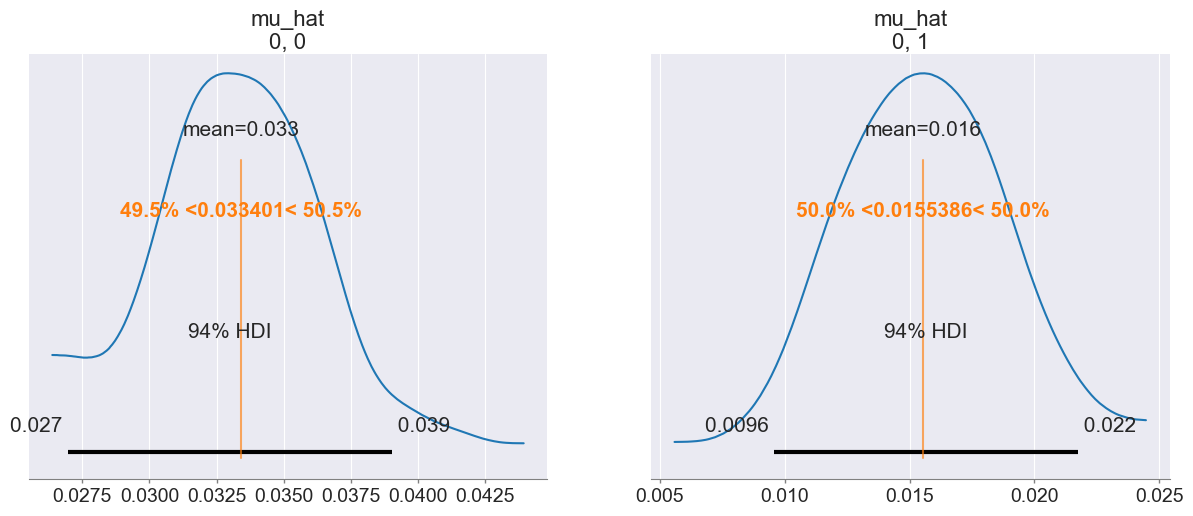

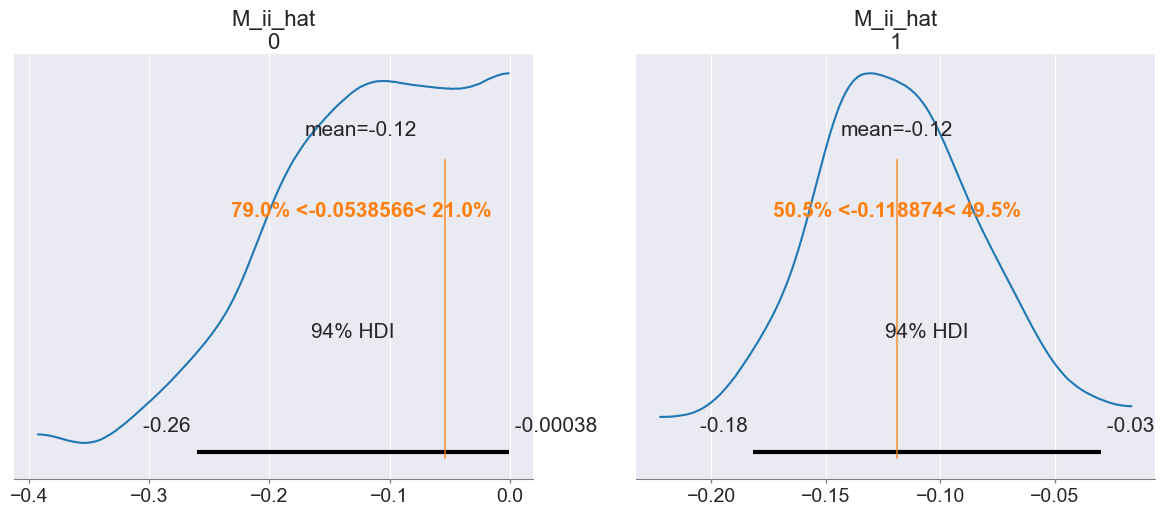

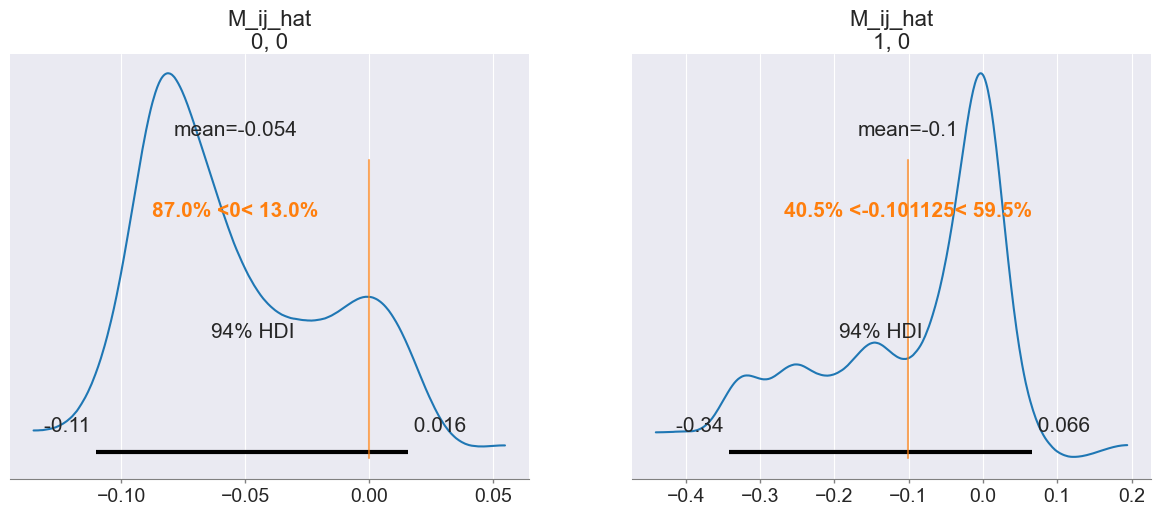

In [11]:
inference = infergLVbayes(X, F, DA=DA, N=N, noise_stddev=noise_stddev)
idata = inference.run_bayes_gLV_shrinkage()

In [12]:
# Print summary

summary = az.summary(idata, var_names=["mu_hat", "M_ii_hat", "M_ij_hat", "M_hat", "sigma"])
print(summary[["mean", "sd", "r_hat"]])


# Save posterior samples to file
az.to_netcdf(idata, 'model_posterior.nc')

/Users/chaniaclare/anaconda3/bin/python3.12/lib/python3.12/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


                 mean     sd  r_hat
mu_hat[0, 0]    0.033  0.003   1.02
mu_hat[0, 1]    0.016  0.003   1.04
M_ii_hat[0]    -0.124  0.081   1.02
M_ii_hat[1]    -0.119  0.040   1.05
M_ij_hat[0, 0] -0.054  0.038   1.02
M_ij_hat[1, 0] -0.101  0.129   1.01
M_hat[0, 0]    -0.054  0.038   1.02
M_hat[0, 1]     0.000  0.000    NaN
M_hat[1, 0]    -0.101  0.129   1.01
M_hat[1, 1]    -0.119  0.040   1.05
sigma[0]        0.007  0.001   1.02


'model_posterior.nc'

(2, 100, 2, 2)
(2, 100, 1, 2)
Using the following parameters for gLV simulation: {'num_species': 2, 'mu': array([0.03341947, 0.01551087]), 'M': array([[-0.06556574,  0.        ],
       [-0.04889016, -0.11977488]]), 'epsilon': array([], shape=(2, 0), dtype=float64)}


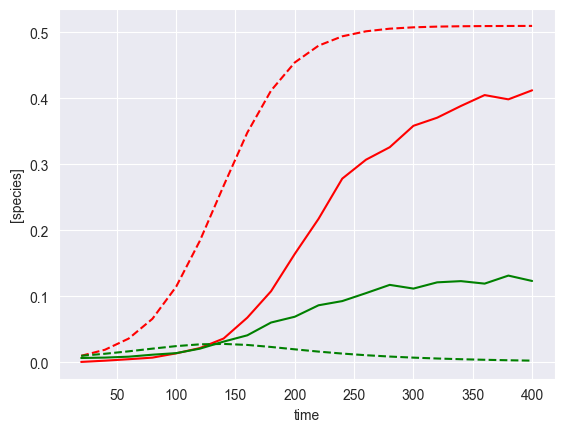

In [13]:
# Compare model parameters to the data
num_species = F.shape[1]
#init_species = 10 * np.ones(num_species)
init_species = 0.01 * np.ones(num_species)

print( idata.posterior["M_hat"].values.shape )

print( idata.posterior["mu_hat"].values.shape )

# # get median posterior values   
M_h = np.median(idata.posterior["M_hat"].values, axis=(0,1))

mu_h = np.median(idata.posterior["mu_hat"].values, axis=(0, 1))
mu_h = mu_h.flatten()

#mu_h = idata.posterior['mu_hat'].mean(dim=('chain', 'draw')).values.flatten()
#M_h= idata.posterior['M_hat'].mean(dim=('chain', 'draw')).values

predictor = sim_gLV(num_species=num_species,
                    M=M_h,
                    mu=mu_h
                 )
yobs_h, _, _, _, _ = predictor.simulate(times=times, init_species=init_species)

plot_fit_gLV(yobs, yobs_h, times)
#compare_params(mu=(mu, mu_h), M=(M, M_h) )